

**Title: NY Stocks Prices Forecasting Using LSTM With Trainable Initial Hidden States**

<table>
<thead>
<tr class="header">
<th>Written by:</th>
<th><p>Sagi Cohen</p>
<p>Oren Fivel</p></th>
</tr>
</thead>
<tbody>
<tr class="odd">

</tr>
</tbody>
</table>

  


**1. Introduction**
================

In this project we try an untraditional approach to forecast financial time series (NY stocks prices) based on LSTM arichitecture with TIHS (trainable initial hidden state) values as described in [1]. We trained our model in an unsupersived manner. The taken approach is based on reconstruction of the data many times from the TIHS values (functioning as encoder for the financial time series) and comparing the reconstructed data to the actual data respected to the MSE criterion.
Also we use this method to investigate a lower dimension representations of complicated time series which are the TIHS themselves.


# **2. Dataset and Limitations** 

While the data set used in the paper [1] is Korea Composite Stock Price Index (KOSPI), we used data from the New York Stock Exchange (NYSE).

We took the data base from Kaggle challenge [2].
It includes 500 stocks with five features: "open", "close", "low", "high", "volume".

"open" price is the price of the specific stock in the begining of the trading time period.

"close" price is the price of the specific stock in the end of the trading time period.

"low" price is the lowest price of the specific stock in the trading time period.

"high" price is the highest price of the specific stock in the trading time period.

"volume" is the amount of stocks that were transacted in the trading time period.

In our case the time period is a day and each stock is represented with its symbol.

We had to deal with some limitations our project. First, We used only one feature, the "close" price as it easier to work with to simplify the architecture and runtime (as others do at [1] and [2]). Secondly we also used a moving average filter (with a window size of 5) as suggested in many papers including the main one [1] in order to handle the noisiness of the financial time series. Later we normalized each stock sequence according to the first day with the following procedure: $\hat{y}_t^k=\frac{price_t^k-price_1^k}{price_1^k}$. That way we track down the change of each stock from its first day in the data set. Finally we also dropped down few stocks that had shorter sequences from most of the stocks because we assumed that they are less stable and harder to train on from the others. At last, we were left with 467 stocks out of 500. Each stock is a time series of 1762 days with 1 feature per day.

Due to large run times, we took only 110 first days of each stock and splitted the first 90 days for training and the 20 left for test.

The following codes details all the proccess done on the data and visually show some of it.


In [ ]:
import numpy as np
import scipy as sp
from scipy import signal
import pandas as pd
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from operator import itemgetter

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# define constants
SEQUENCE_LENGTH = 1762
NUM_FEATURES = 4
NUM_OF_STOCKS = 467

In [ ]:
# load data - import all stocks features
df = pd.read_csv("C:/Users/", index_col = 0) #put your on directory
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 851264 entries, 2016-01-05 to 2016-12-30
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   symbol  851264 non-null  object 
 1   open    851264 non-null  float64
 2   close   851264 non-null  float64
 3   low     851264 non-null  float64
 4   high    851264 non-null  float64
 5   volume  851264 non-null  float64
dtypes: float64(5), object(1)
memory usage: 45.5+ MB


,symbol,open,close,low,high,volume
date,,,,,,
2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [ ]:
# number of different stocks
print('\nnumber of different stocks: ', len(list(set(df.symbol))))
print(list(set(df.symbol))[:10])



number of different stocks:  501
['ULTA', 'AMAT', 'K', 'MTB', 'WFM', 'XRX', 'SE', 'FSLR', 'TXT', 'ALK']


In [ ]:
# data description
print(df.tail())
print(df.describe())
print(df.info())

           symbol        open       close         low        high     volume
date                                                                        
2016-12-30    ZBH  103.309998  103.199997  102.849998  103.930000   973800.0
2016-12-30   ZION   43.070000   43.040001   42.689999   43.310001  1938100.0
2016-12-30    ZTS   53.639999   53.529999   53.270000   53.740002  1701200.0
2016-12-30    AIV   44.730000   45.450001   44.410000   45.590000  1380900.0
2016-12-30    FTV   54.200001   53.630001   53.389999   54.480000   705100.0
                open          close            low           high  \
count  851264.000000  851264.000000  851264.000000  851264.000000   
mean       64.993618      65.011913      64.336541      65.639748   
std        75.203893      75.201216      74.459518      75.906861   
min         1.660000       1.590000       1.500000       1.810000   
25%        31.270000      31.292776      30.940001      31.620001   
50%        48.459999      48.480000      47.970

In [ ]:
# create symbols list of all stocks from data
all_stock_symb_list = list(set(df.symbol))

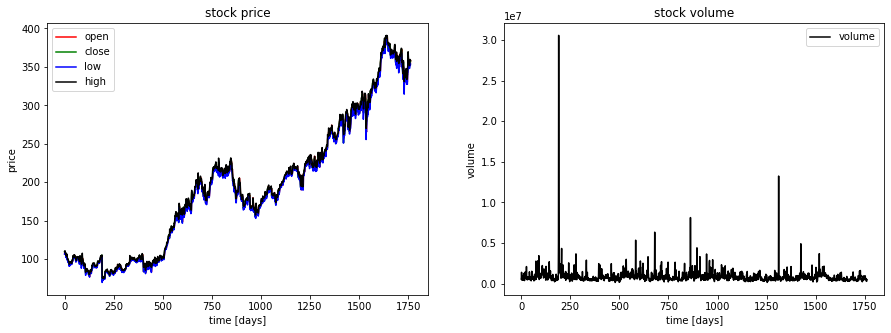

In [ ]:
# example plots from data
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);
plt.plot(df[df.symbol == 'EQIX'].open.values, color='red', label='open')
plt.plot(df[df.symbol == 'EQIX'].close.values, color='green', label='close')
plt.plot(df[df.symbol == 'EQIX'].low.values, color='blue', label='low')
plt.plot(df[df.symbol == 'EQIX'].high.values, color='black', label='high')
plt.title('stock price')
plt.xlabel('time [days]')
plt.ylabel('price')
plt.legend(loc='best')

plt.subplot(1,2,2);
plt.plot(df[df.symbol == 'EQIX'].volume.values, color='black', label='volume')
plt.title('stock volume')
plt.xlabel('time [days]')
plt.ylabel('volume')
plt.legend(loc='best')
plt.show()

In [ ]:
# choose one stock
df_stock = df[df.symbol == 'ITW'].copy()
df_stock.drop(['symbol'],1,inplace=True)
df_stock.drop(['volume'],1,inplace=True)

cols = list(df_stock.columns.values)
print('df_stock.columns.values = ', cols)

df_stock.columns.values =  ['open', 'close', 'low', 'high']


In [ ]:
# data normalization
""" normalazing all data at once. 
normalization according to the paper, for each stock:
y_t = (y_t - y_0) / y_0 """
def normalize_by_sub(data_):
    data = data_.copy()
    stock_num = np.shape(data)[0]
    len_seq = np.shape(data)[1]
    for stock_idx in range(stock_num):
        y_0 = data[stock_idx][0][1] # index 1 for close feature
        for t in range(len_seq):
            data[stock_idx][t][1] = (data[stock_idx][t][1] - y_0)/(y_0)
    return data

In [ ]:
# moving average function
def moving_average(x, w):
    ret_ = sp.signal.convolve(x, np.ones(w), 'valid') / w
    return np.append(ret_,np.zeros(w - 1))


In [ ]:
# create train, test data
""" this function takes panda dataframe and desired sizes for train/val/test.
it looks for all relvant (long enough) stocks and procces them to
further use. Data returns as np.arrays normalized and reshaped for lstm model. """
def create_data(df,train_size,val_size,test_size):
    ret_stock_arr = np.zeros((1,SEQUENCE_LENGTH,NUM_FEATURES))
    new_symb_list =[]
    for symb in all_stock_symb_list:
        temp_stock = df[df.symbol == symb].copy()
        # dropping shorter stocks
        if np.shape(temp_stock)[0] != SEQUENCE_LENGTH:
            continue
        # updating symbol list to used stocks only
        new_symb_list.append(symb)
        # dropping un-needed features
        temp_stock.drop(['symbol'],1,inplace=True)
        temp_stock.drop(['volume'],1,inplace=True)
        temp_stock_append = temp_stock.copy()
        temp_stock_append = temp_stock_append.values
        temp_stock_append = np.array(temp_stock_append)
        temp_stock_append = temp_stock_append.reshape(1,np.shape(temp_stock_append)[0],np.shape(temp_stock_append)[1])
        ret_stock_arr = np.concatenate((ret_stock_arr, temp_stock_append), axis=0)
    # removing first empty stock we created
    ret_stock_arr = np.delete(ret_stock_arr,0,0)
    # applying moving average for each stock
    for i in range (len(new_symb_list)):
        ret_stock_arr[i,:,1] = moving_average(ret_stock_arr[i,:,1], 5)
    #normalazing all used stocks at once
    ret_stock_arr = normalize_by_sub(ret_stock_arr)
    # sending out data with desired sequence size and using only "close" feature
    x_train = ret_stock_arr[:,:train_size,1]
    x_valid = ret_stock_arr[:,:train_size+val_size,1]
    x_test = ret_stock_arr[:,:train_size+val_size+test_size,1]
    # reshaping for later use as tensors
    x_train = x_train.reshape(np.shape(x_train)[0],np.shape(x_train)[1],1)
    x_valid = x_valid.reshape(np.shape(x_valid)[0],np.shape(x_valid)[1],1)
    x_test = x_test.reshape(np.shape(x_test)[0],np.shape(x_test)[1],1)
    return x_train , x_valid , x_test , new_symb_list


In [ ]:
x_train, x_valid , x_test , stock_symb_list = create_data(df, 90, 10, 10)

In [ ]:
# creating a dictionary of numbered stock symbols from updated relevant symb_list
stock_symb_dict = dict(zip(stock_symb_list,range(len(stock_symb_list))))

In [ ]:
# print data shape after preproccessing
print('x_train.shape = ',x_train.shape)
print('x_test.shape = ', x_test.shape)

x_train.shape =  (467, 90, 1)
x_test.shape =  (467, 110, 1)


# **3. Network**


The following diagram represents our model architecture:



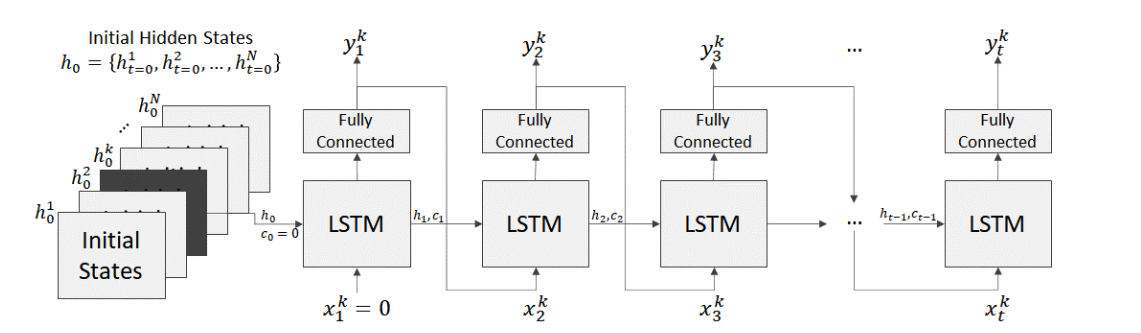


The model represented above is a reconstructive LSTM (in our case 128\64 cells). It uses all the data ($k=1,2...,N$) as one batch (in our case always N = 467). We initialize it (in time $t = 1$) with input vectors ($x_1$'s) and cell vectors ($c_0$'s) of zeros and the trained initial hidden values ($h_0$'s) for all the stocks. The next stage is a fully connected layer that takes $h_1$'s and generates outputs $y_1$'s (128 to 1). The output is fed back to the input at the next time step to create a closed loop generation. This way the model constructs time sequences of data from the initial hidden states in desired lenght.
Summarizing the equations:

The initial hidden state to be learned
\begin{equation}
h_{t=0}=[h_0^1,h_0^2,...,h_0^N]
\end{equation}
LSTM step
\begin{equation}
(h_t^k, c_t^k) =LSTM(x_t^k,(h_{t-1}^k,c_{t-1}^k))
\end{equation}
Fully conected step
\begin{equation}
\begin{split}
y_t^k&=Linear(h_t^k) \\
x_{t+1}^k&=y_t^k,t>0 \\
x_1^k&=0
\end{split}
\end{equation}

Note that the model considers only the lenght (of time series) of the data and does not use any of the actual values of the data in this stage of reconstructing. The training occurs later when the reconstructed data is compared to the real train data based on MSE criterion. Also, the ADAM optimizer was used with various parameters.




**Code implementation of LSTM with trainable initial hidden states**

In [ ]:
class MODEL_LSTM_TIHS(nn.Module): # "TIHS" = trainable initial hidden states
    def __init__(self,input_size=1, hidden_layer_size=128, output_size=1 , batch_size = NUM_OF_STOCKS):
        super().__init__()
        self.batch_size = batch_size
        self.input_size = input_size
        self.output_size = output_size
        self.numLayers = 1
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(in_features =  self.hidden_layer_size,
                                out_features = self.output_size)
        # setting trainable initial hidden states
        h0 = torch.zeros(self.input_size,self.batch_size,self.hidden_layer_size).to(device)
        self.h0 = nn.Parameter(h0, requires_grad=True).to(device)

    def forward(self, inp, shf): 
        seqLength = inp.shape[1]
        numDataInBatch = inp.shape[0]
        # reconstructing time series of desired lenght
        for t in range(seqLength):
            if(t ==0):
                # shuffling h0 respectivley to same shf of stocks in train
                if (shf != None):
                    h_t = self.h0.transpose(0,1)
                    h_t = h_t[shf].view(h_t.size())
                    h_t = h_t.transpose(0,1)
                else:
                    h_t = self.h0
                # setting c0 and x1 to zeros in t = 1
                c_t = torch.zeros(self.numLayers, numDataInBatch, self.hidden_layer_size).to(device)
                x_t = torch.zeros(1, numDataInBatch, self.input_size).to(device)
            else:
                x_t = y_t
            # feedback loop
            y_t, (h_t, c_t) = self.lstm(x_t, (h_t, c_t))

            y_t = self.linear(h_t)

            if (t == 0):
                outputs = y_t
            else:
                outputs = torch.cat((outputs,y_t),0)

        return outputs

# **4. Benchmark**


While training, we tried to minimize the MSE loss between our reconstructed data and the real data.

As for the test, we will check both RMSE & MAE and for each stock series and examine our performance in respect to those. We will represent later our results compared to two other works of stocks forecasting represented in [3] & [4].


In [ ]:
def run_model(model,
              train_data_xs = x_train,
              validation_data_xs = x_valid,
              batch_size = NUM_OF_STOCKS,
              learning_rate = 0.001,
              weight_decay = 0,
              max_iters = 1500,
              checkpoint_path = None,
              is_train = False):
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(),
                           lr=learning_rate,
                           weight_decay=weight_decay)
      
    iters, iters_val, train_losses ,valid_losses = [], [] , [] , []
    temp_valid = 1
    
    if (is_train == True):
        n = 0 # the number of iterations
        while True:
            # convert data to shuffeled tensors
            shf_idx = torch.randperm(train_data_xs.shape[0])
            stocks_train_seqs = torch.tensor(train_data_xs).type(torch.FloatTensor)
            stocks_train_seqs = stocks_train_seqs[shf_idx].view(stocks_train_seqs.size())
            # call forward with same shuffle
            stock_seqs_from_model = model.forward(stocks_train_seqs.to(device),shf_idx)                
            optimizer.zero_grad()
            loss_train = criterion(stock_seqs_from_model.to(device)
                                   ,stocks_train_seqs.transpose(0, 1).to(device)) 
            loss_train.backward()                      
            optimizer.step()

            iters.append(n)
            train_losses.append(float(loss_train.clone()))  
    
            if (n+1) % 10 == 0:
                # checking procces
                stocks_valid_seqs = torch.tensor(validation_data_xs).type(torch.FloatTensor)
                stock_from_model_valid = model.forward(stocks_valid_seqs.to(device), None)                
                loss_valid = criterion(stock_from_model_valid.to(device),
                                       stocks_valid_seqs.transpose(0, 1).to(device))
                # saving current model if better
                if (checkpoint_path is not None) and (loss_valid<temp_valid):
                    torch.save(model.state_dict(), checkpoint_path)
                
                temp_valid = loss_valid
                iters_val.append(n+1)
                valid_losses.append(float(loss_valid.clone()))
                print("[Iter %d] Train Loss: %f Val Loss: %f" % (n+1, float(loss_train),float(loss_valid)))
               
            # increment the iteration number
            n += 1
    
            if n > max_iters:
                return iters, train_losses, iters_val, valid_losses

    else: # running test (is_train = False)
        stocks_test_seqs = torch.tensor(train_data_xs).type(torch.FloatTensor)
        stock_from_model_test = model.forward(stocks_test_seqs.to(device), None)                
        loss_test = criterion(stock_from_model_test.to(device),
                                   stocks_test_seqs.transpose(0, 1).to(device))
        return stock_from_model_test , float(loss_test.clone())
            

In [ ]:
def plot_learning_curve(iters_train, train_losses, iters_val, valid_losses):
    
    plt.title("Learning Curve: Loss per Iteration")
    plt.plot(iters_train, train_losses, label="Train")
    plt.plot(iters_val, valid_losses, label="Valid")#,linestyle='dashed')
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

def plot_test_example(pred,test,stock_indx,pred_lenght):
    """ pred, test values are np.arr with shape of
        [num_of_stocks , seq_len, feature] """
    pred_seq = pred[:,stock_indx,0].tolist()
    seq_len = len(pred_seq) 
    test = test[stock_indx,:,0].tolist()
    pred1 = np.swapaxes(pred,0,1)
    mse = ((pred1 - test)**2).mean(axis=None)
    rmse=mse**0.5
    mae=(np.absolute(pred1 - test)).mean(axis=None)
    plt.title('Test compression: Stock num. %d: %s' % (stock_indx,stock_symb_list[stock_indx]))    
    plt.plot(range(seq_len), test, label="Real Sequence")
    plt.plot(range(seq_len)[:-pred_lenght], pred_seq[:-pred_lenght], label="Reconstructed Sequence")#,linestyle='dashed')
    plt.plot(range(seq_len)[-(pred_lenght+1):], pred_seq[-(pred_lenght+1):], label="Predicted Sequence",color='green')#,linestyle='dashed')
    plt.xlabel("Time [Days]")
    plt.ylabel("Price [Normalized]")
    plt.legend()
    plt.show()
    print('RMSE: %f ; MAE: %f\n\n'% (rmse,mae))
    return mse, rmse, mae 

# **5. Results**


We examined few model parameter setups, most of them represented in training cells & graphs below.

The learning rate was set between 0.1 and 0.001.

We examined both 64 and 128 LSTM cells cases.

Training time was between 10,000 and 150,000 iterations.

We set our initial values to be close to paper [1] and explored various changes.
Eventually, best results were for the model architecture that consisted of 128 LSTM cells. The learning rate was set to 0.001 and the model was trained for 150,000 iterations to get our desired results (first case below).

Some of the graphs look like we could stop the train earlier and it may be true but we did get better results this way. The loss is very low so it is hard to notice the changes in loss graph.

As for our choice of model, it looks like many of the training proccesess and loss values are the same, but in our chosen model, one can really see the difference in the predictions graphs and benchmarks. 
The graphs represented below are some of the best stock prediction results we got in general (for all models).

Please note that both our model and method of work requires a lot computing of resources. This is due to the unsupervised-like learning and the amount of the data. Therefore we could not check many more cases of different hyper-parameters or sequences longer than 90 days.

In [ ]:
# best model!!!
model = MODEL_LSTM_TIHS(input_size=1, hidden_layer_size=128, output_size=1 ).to(device)
iters, train_losses, iters_val, valid_losses = run_model(model,
                                                          x_train,
                                                          x_valid,
                                                          learning_rate = 0.001,
                                                          weight_decay = 0,
                                                          max_iters = 150000,
                                                          checkpoint_path="C:/Users/.../best_model_90_150_new.pk",
                                                          is_train = True)

plot_learning_curve(iters, train_losses, iters_val, valid_losses)


In [ ]:
# load best model of last training
best_model = MODEL_LSTM_TIHS(input_size=1, hidden_layer_size=128, output_size=1 ).to(device)
best_model.load_state_dict(torch.load("C:/Users/.../best_model_90_150_new.pk"))
test_pred , test_loss= run_model(best_model,x_test)
test_pred_arr = np.array(test_pred.cpu().detach())


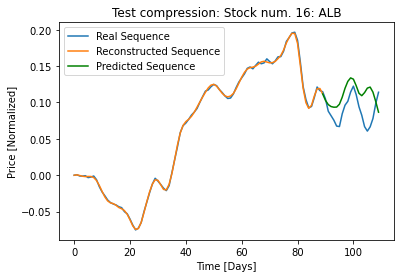

RMSE: 0.150239 ; MAE: 0.117953




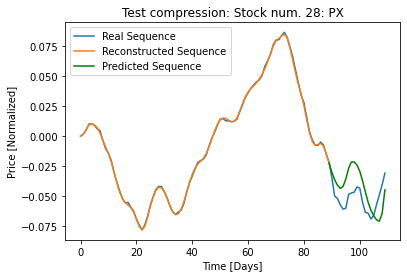

RMSE: 0.138972 ; MAE: 0.100762




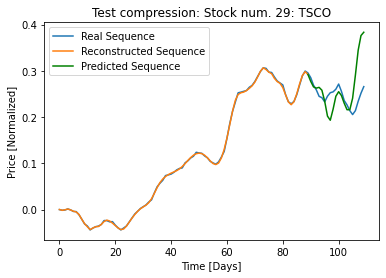

RMSE: 0.202520 ; MAE: 0.164058




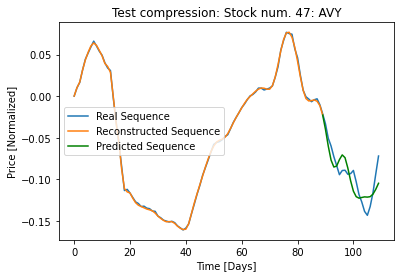

RMSE: 0.165061 ; MAE: 0.124804




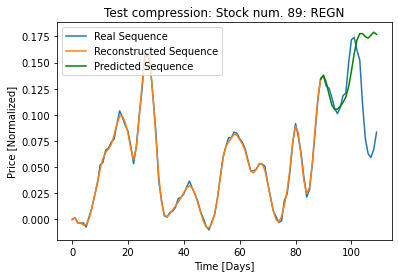

RMSE: 0.136679 ; MAE: 0.104202




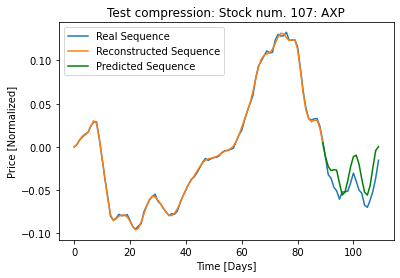

RMSE: 0.145238 ; MAE: 0.107721




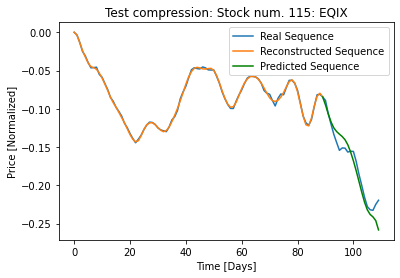

RMSE: 0.185384 ; MAE: 0.144310




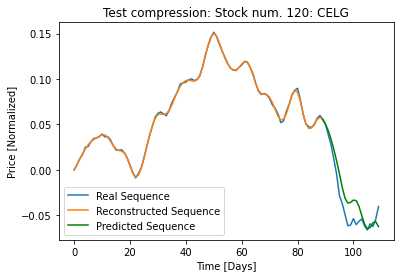

RMSE: 0.137813 ; MAE: 0.105078




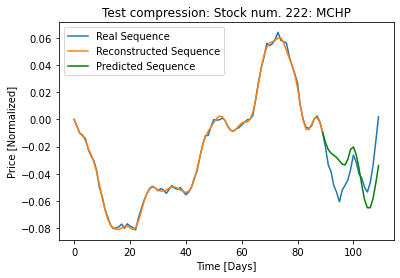

RMSE: 0.140631 ; MAE: 0.101402




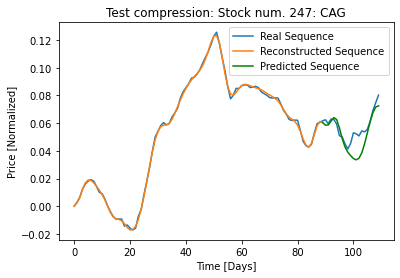

RMSE: 0.131985 ; MAE: 0.100179




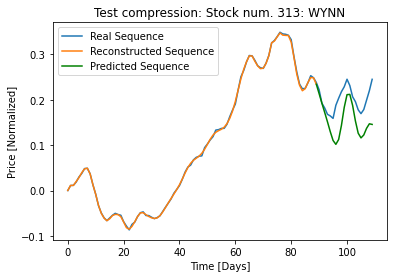

RMSE: 0.203827 ; MAE: 0.164620




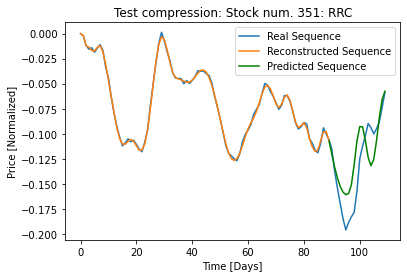

RMSE: 0.172183 ; MAE: 0.131314




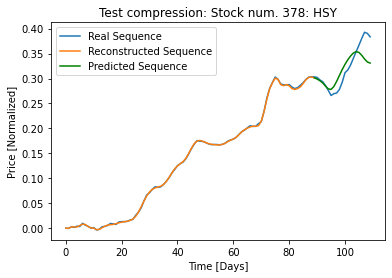

RMSE: 0.221576 ; MAE: 0.181539




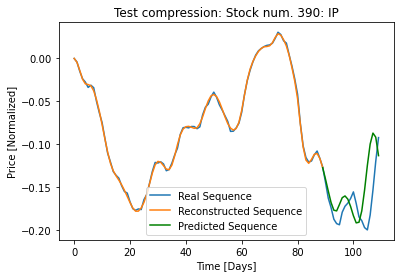

RMSE: 0.185364 ; MAE: 0.144065




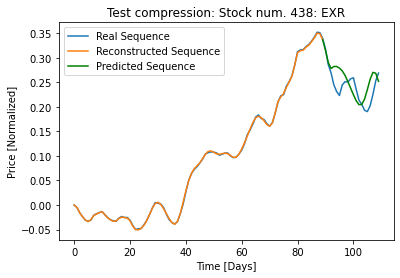

RMSE: 0.197219 ; MAE: 0.156821




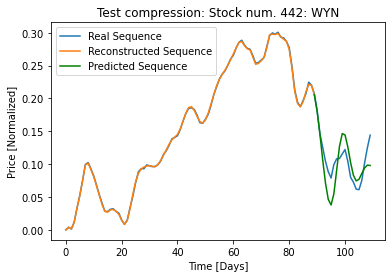

RMSE: 0.193498 ; MAE: 0.158584




In [ ]:
best_mse_list, best_rmse_list, best_mae_list = [],[],[]
pred_lenght = x_test.shape[1] - x_train.shape[1]
list_of_chosen_stocks = [16,28,29,47,89,107,115,120,222,247,313,351,378,390,438,442]
for stock_idx in list_of_chosen_stocks:
    
    temp_mse, temp_rmse, temp_mae = plot_test_example(test_pred_arr, x_test, stock_idx, pred_lenght)
    best_mse_list.append(temp_mse)
    best_rmse_list.append(temp_rmse)
    best_mae_list.append(temp_mae)


In [ ]:
model = MODEL_LSTM_TIHS(input_size=1, hidden_layer_size=128, output_size=1 ).to(device)
iters, train_losses, iters_val, valid_losses = run_model(model,
                                                          x_train,
                                                          x_valid,
                                                          learning_rate = 0.01,
                                                          weight_decay = 0,
                                                          max_iters = 50000,
                                                          checkpoint_path="C:/Users/.../best_model_90_50.pk",
                                                          is_train = True)

plot_learning_curve(iters, train_losses, iters_val, valid_losses)


In [ ]:
# load best model of last training
best_model = MODEL_LSTM_TIHS(input_size=1, hidden_layer_size=128, output_size=1 ).to(device)
best_model.load_state_dict(torch.load("C:/Users/sagic/..../best_model_90_50.pk"))
test_pred , test_loss= run_model(best_model,x_test)
test_pred_arr = np.array(test_pred.cpu().detach())


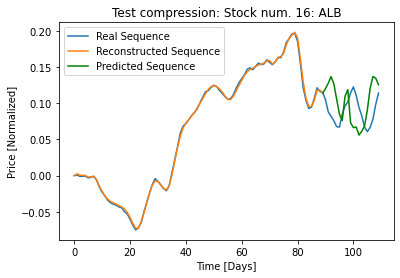

RMSE: 0.147692 ; MAE: 0.115831




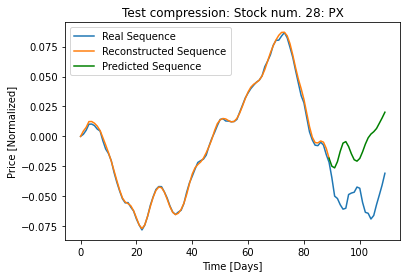

RMSE: 0.138632 ; MAE: 0.100588




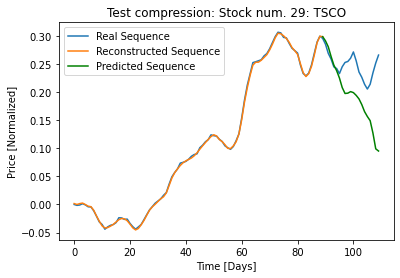

RMSE: 0.199318 ; MAE: 0.161490




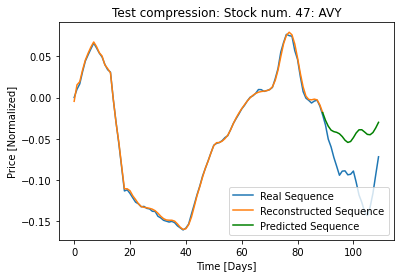

RMSE: 0.165732 ; MAE: 0.125455




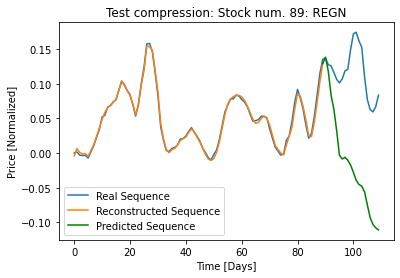

RMSE: 0.134135 ; MAE: 0.102285




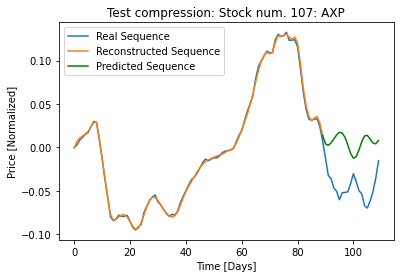

RMSE: 0.144775 ; MAE: 0.107399




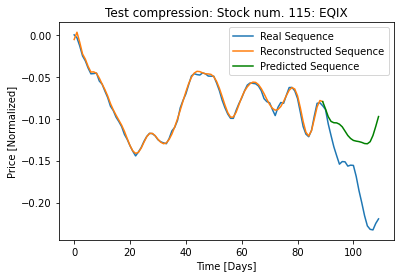

RMSE: 0.187021 ; MAE: 0.145997




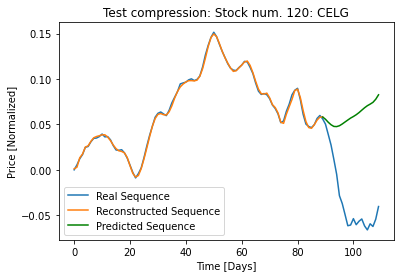

RMSE: 0.135630 ; MAE: 0.103401




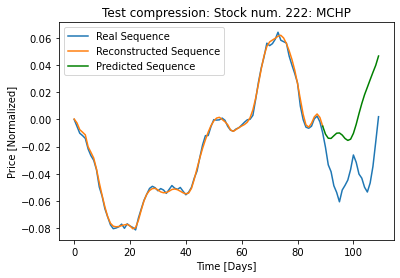

RMSE: 0.140602 ; MAE: 0.101484




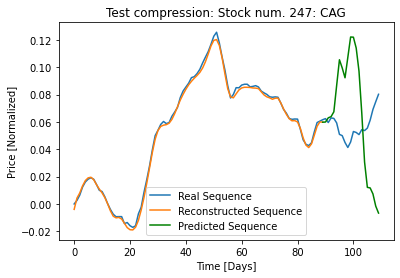

RMSE: 0.129525 ; MAE: 0.098372




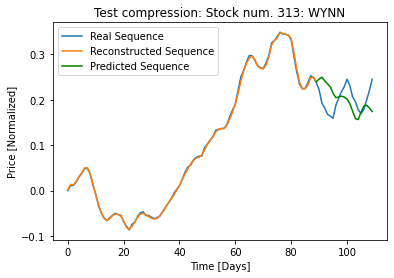

RMSE: 0.200934 ; MAE: 0.162331




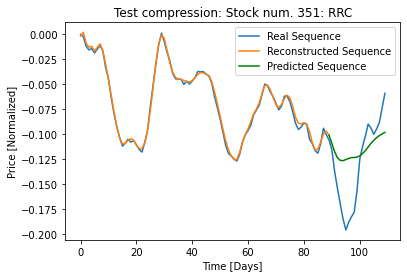

RMSE: 0.173521 ; MAE: 0.132644




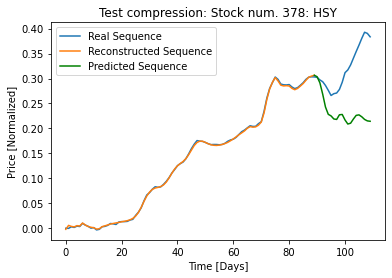

RMSE: 0.217989 ; MAE: 0.178483




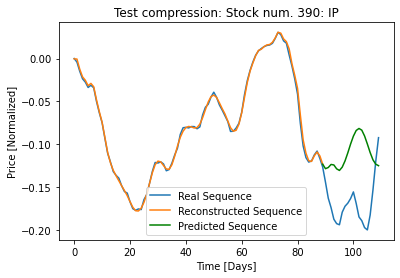

RMSE: 0.186843 ; MAE: 0.145579




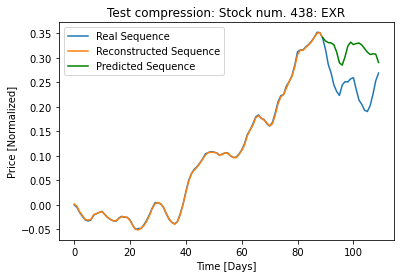

RMSE: 0.194282 ; MAE: 0.154483




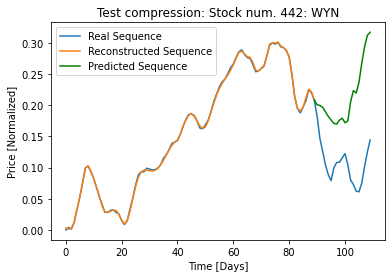

RMSE: 0.189812 ; MAE: 0.155392




In [ ]:
mse_list, rmse_list, mae_list = [],[],[]
pred_lenght = x_test.shape[1] - x_train.shape[1]
list_of_chosen_stocks = [16,28,29,47,89,107,115,120,222,247,313,351,378,390,438,442]
for stock_idx in list_of_chosen_stocks:
    
    temp_mse, temp_rmse, temp_mae = plot_test_example(test_pred_arr, x_test, stock_idx, pred_lenght)
    mse_list.append(temp_mse)
    rmse_list.append(temp_rmse)
    mae_list.append(temp_mae)

In [ ]:
model = MODEL_LSTM_TIHS(input_size=1, hidden_layer_size=64, output_size=1 ).to(device)
iters, train_losses, iters_val, valid_losses = run_model(model,
                                                          x_train,
                                                          x_valid,
                                                          learning_rate = 0.01,
                                                          weight_decay = 0,
                                                          max_iters = 50000,
                                                          checkpoint_path="C:/Users/..../best_model_64.pk",
                                                          is_train = True)

plot_learning_curve(iters, train_losses, iters_val, valid_losses)

In [ ]:
# load best model of last training
best_model = MODEL_LSTM_TIHS(input_size=1, hidden_layer_size=64, output_size=1 ).to(device)
best_model.load_state_dict(torch.load("C:/Users/.../best_model_64.pk"))
test_pred , test_loss= run_model(best_model,x_test)
test_pred_arr = np.array(test_pred.cpu().detach())

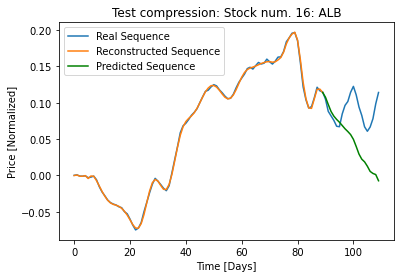

RMSE: 0.150497 ; MAE: 0.117974




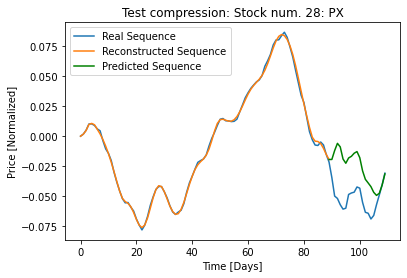

RMSE: 0.138912 ; MAE: 0.099859




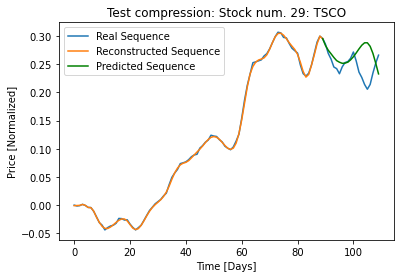

RMSE: 0.202897 ; MAE: 0.164252




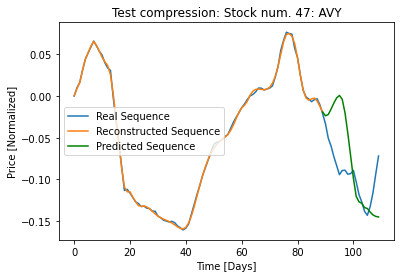

RMSE: 0.164874 ; MAE: 0.123857




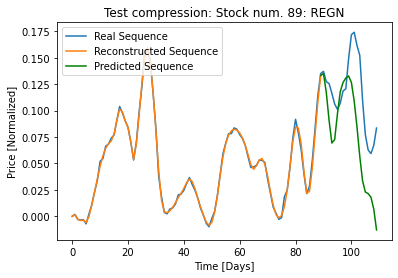

RMSE: 0.136926 ; MAE: 0.104193




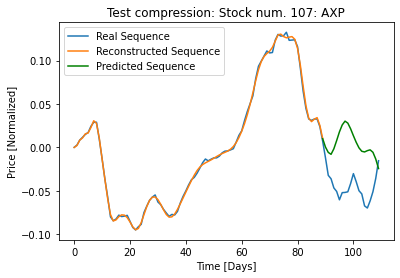

RMSE: 0.145200 ; MAE: 0.106916




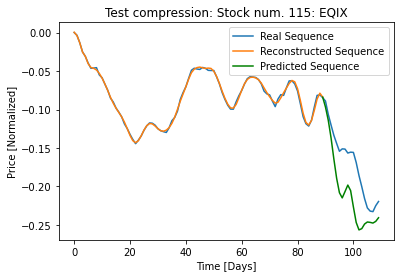

RMSE: 0.185069 ; MAE: 0.143009




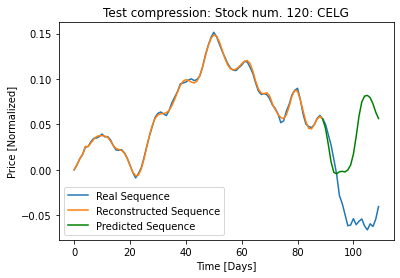

RMSE: 0.138012 ; MAE: 0.104962




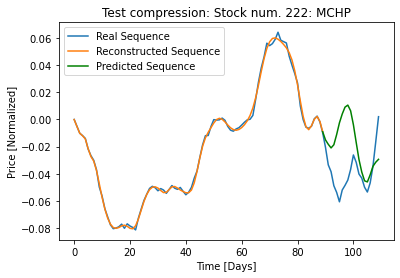

RMSE: 0.140527 ; MAE: 0.100361




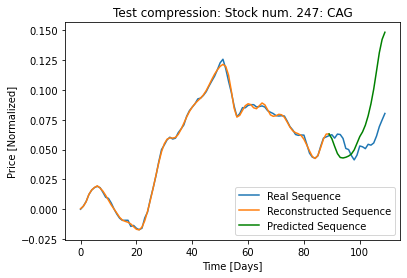

RMSE: 0.132217 ; MAE: 0.100147




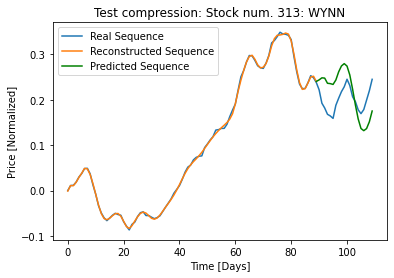

RMSE: 0.204161 ; MAE: 0.164694




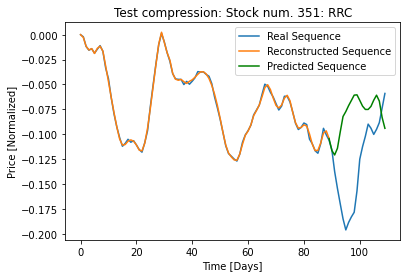

RMSE: 0.171904 ; MAE: 0.130006




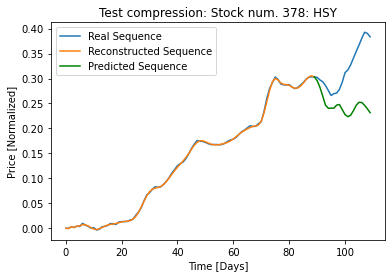

RMSE: 0.222013 ; MAE: 0.181974




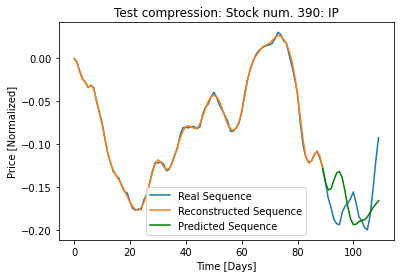

RMSE: 0.185072 ; MAE: 0.142928




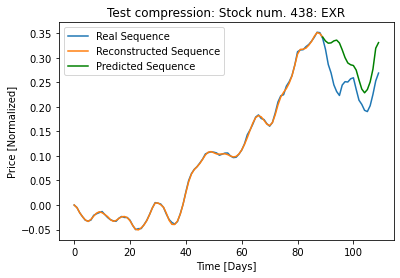

RMSE: 0.197556 ; MAE: 0.156890




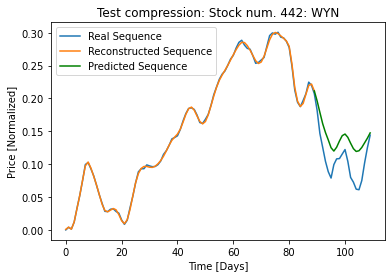

RMSE: 0.193938 ; MAE: 0.159115




In [ ]:
mse_list, rmse_list, mae_list = [],[],[]
pred_lenght = x_test.shape[1] - x_train.shape[1]
list_of_chosen_stocks = [16,28,29,47,89,107,115,120,222,247,313,351,378,390,438,442]
for stock_idx in list_of_chosen_stocks:
    
    temp_mse, temp_rmse, temp_mae = plot_test_example(test_pred_arr, x_test, stock_idx, pred_lenght)
    mse_list.append(temp_mse)
    rmse_list.append(temp_rmse)
    mae_list.append(temp_mae)

In [ ]:
model = MODEL_LSTM_TIHS(input_size=1, hidden_layer_size=128, output_size=1 ).to(device)
iters, train_losses, iters_val, valid_losses = run_model(model,
                                                          x_train,
                                                          x_valid,
                                                          learning_rate = 0.001,
                                                          weight_decay = 0,
                                                          max_iters = 100000,
                                                          checkpoint_path="C:/Users/.../best_model_128_100.pk",
                                                          is_train = True)

plot_learning_curve(iters, train_losses, iters_val, valid_losses)

In [ ]:
# load best model of last training
best_model = MODEL_LSTM_TIHS(input_size=1, hidden_layer_size=128, output_size=1 ).to(device)
best_model.load_state_dict(torch.load("C:/Users/..../best_model_128_100.pk"))
test_pred , test_loss= run_model(best_model,x_test)
test_pred_arr = np.array(test_pred.cpu().detach())

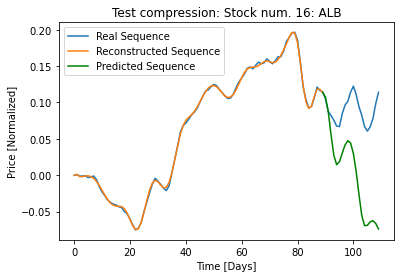

RMSE: 0.147882 ; MAE: 0.117524




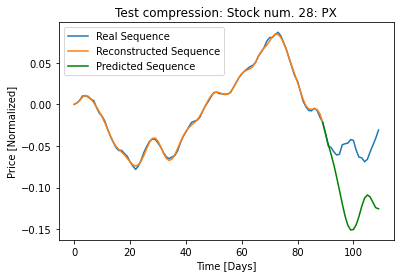

RMSE: 0.133820 ; MAE: 0.097455




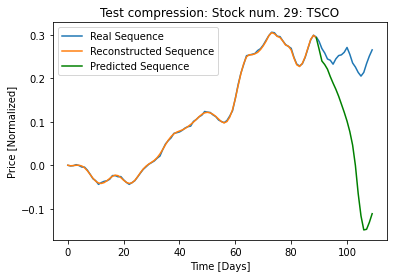

RMSE: 0.202163 ; MAE: 0.164506




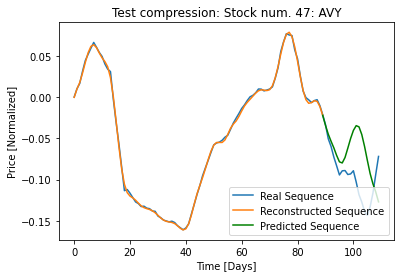

RMSE: 0.159703 ; MAE: 0.120706




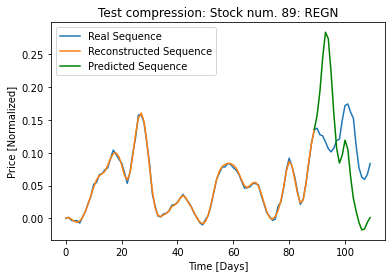

RMSE: 0.133807 ; MAE: 0.103784




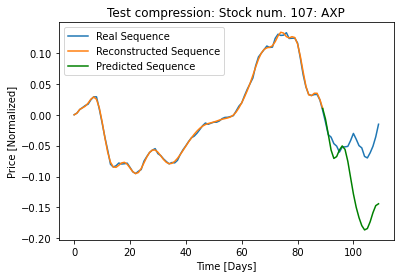

RMSE: 0.140467 ; MAE: 0.104579




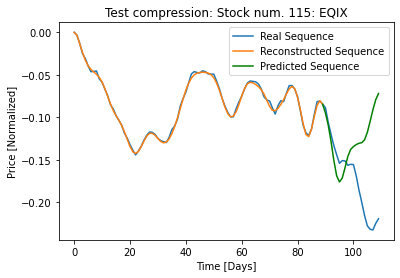

RMSE: 0.179490 ; MAE: 0.138669




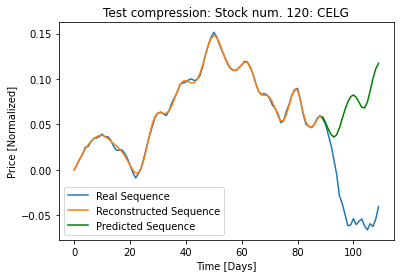

RMSE: 0.134605 ; MAE: 0.104237




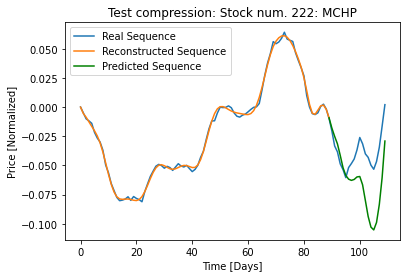

RMSE: 0.135203 ; MAE: 0.097653




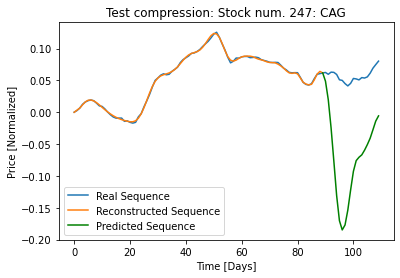

RMSE: 0.128823 ; MAE: 0.099689




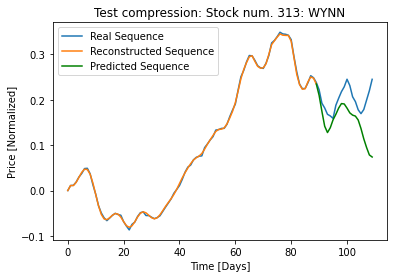

RMSE: 0.203173 ; MAE: 0.164574




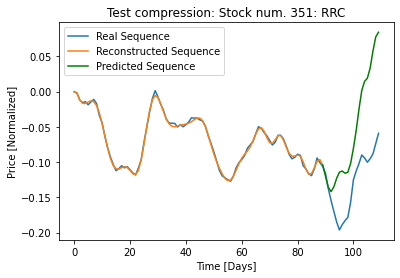

RMSE: 0.166289 ; MAE: 0.125917




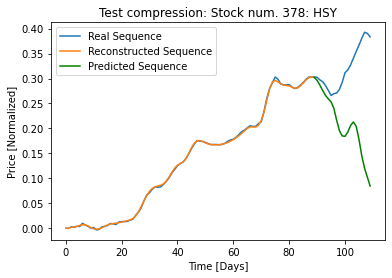

RMSE: 0.221942 ; MAE: 0.182820




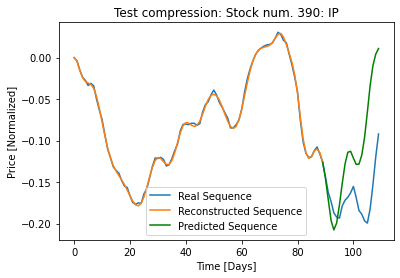

RMSE: 0.179645 ; MAE: 0.138972




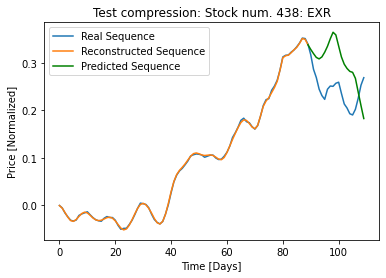

RMSE: 0.196484 ; MAE: 0.156836




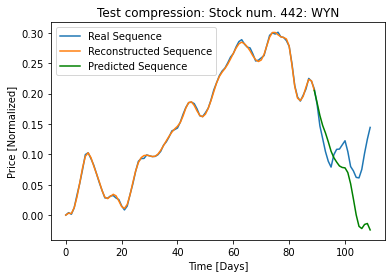

RMSE: 0.193469 ; MAE: 0.159978




In [ ]:
mse_list, rmse_list, mae_list = [],[],[]
pred_lenght = x_test.shape[1] - x_train.shape[1]
list_of_chosen_stocks = [16,28,29,47,89,107,115,120,222,247,313,351,378,390,438,442]
for stock_idx in list_of_chosen_stocks:
    
    temp_mse, temp_rmse, temp_mae = plot_test_example(test_pred_arr, x_test, stock_idx, pred_lenght)
    mse_list.append(temp_mse)
    rmse_list.append(temp_rmse)
    mae_list.append(temp_mae)

In [ ]:
model = MODEL_LSTM_TIHS(input_size=1, hidden_layer_size=64, output_size=1 ).to(device)
iters, train_losses, iters_val, valid_losses = run_model(model,
                                                          x_train,
                                                          x_valid,
                                                          learning_rate = 0.1,
                                                          weight_decay = 0,
                                                          max_iters = 10000,
                                                          checkpoint_path="C:/Users/.../best_model_64_01_10000.pk",
                                                          is_train = True)

plot_learning_curve(iters, train_losses, iters_val, valid_losses)

For this train run, it is obvious that the learning did not go well. We will not show any prediction graph.

# **6. Result analysis**


First we will print results from above:


In [ ]:
print ('Avg RMSE of chosen stocks: %f'%(np.mean(best_rmse_list)))
print ('Avg MAE of chosen stocks: %f'%(np.mean(best_mae_list)))

Avg RMSE of chosen stocks: 0.169262
Avg MAE of chosen stocks: 0.131713


We looked for other works (with different methods) of stock forecasting and examined their results of the same benchmarks.
As we can see in [3] their best results were RMSE between 0.43 and 3.3 for normalized stock, which is worse than ours. As for [4] their best results were RMSE around 15 and MAE around 12 which is probably better than our results since they did normalize back.

On one hand our results show perfect reconstruction which maybe indicates an overfit (will discuss in conclusions), on the other hand our prediction results are not the SOTA.

We can see that in most of the cases, the begining of the prediction (first 10 days) goes quite well and later it gets harder for the model to accurately predict.

Both things mentioned above did also accured in main work [1] (figure 4.(b)).

Also we can see a large difference between train and validation loss. This can be explained by the method of training, as the validation is simply construction of the future of the time series just same as the test. Therefore we do not expect it to be low as the train reconstruction. Also it emphasises earlier mentioned suspicion - model is overfitting. 



# **7. Conclusions** 

In this project we tried to predict future of stock prices (NYSE) using model of LSTM with trainable initial hidden state values under unsupervised manner. The method of work was generating in closed loop stock profiles only from the hidden state values and then comparing them to the actual data.

We did get some good stock predictions overall but we have to be careful with those results for few reasons. First, we think that the main idea of this method is problematic since this unclassic method forces an overfitted model. If we wish to reconstruct data only from the structure of it and initial value, and we train it for long time, it is very likely that the model will have to overfit itself to the initial data. Second, this method requires a lot of resources compared to traditional approaches. 

One more interesting thing is the fact that this method creates a lower dimension representations of time series (financial in our case) in terms of initial hidden state values. In fact it represents them as vectors of initial values.

Although we have some concerns about our results, if one will use this method in the future, we would like to recommend to incorporate more features to the model (high,low,volume) as inputs and keep closing price as output although we are not sure it is trivial in this method of unsupervised manner.

# **8. References**


1.  J. Hwang, “Modeling financial time series using LSTM with trainable initial hidden states,” arXiv [q-fin.ST], 2020. arXiv preprint arXiv:2007.06848.[link](https://arxiv.org/abs/2007.06848)‏ 

2.	D. Gawlik, “New York Stock Exchange.” [Online]. Available: https://www.kaggle.com/dgawlik/nyse. [Accessed: 24-Jul-2021].

3.	M. Vijh, D. Chandola, V. A. Tikkiwal, and A. Kumar, “Stock closing price prediction using machine learning techniques,” Procedia Comput. Sci., vol. 167, pp. 599–606, 2020.[link](https://www.sciencedirect.com/science/article/pii/S1877050920307924)‏

4.	T. Gao and Y. Chai, “Improving stock closing price prediction using recurrent neural network and technical indicators,” Neural Comput., vol. 30, no. 10, pp. 2833–2854, 2018.[link](https://direct.mit.edu/neco/article/30/10/2833/8415)‏